In [1]:
#!pip install folium --upgrade
#!pip install matplotlib
#!pip install seaborn

In [2]:
import pandas as pd
import numpy as np
import urllib.request, json
import matplotlib
import matplotlib.pyplot as plt
import unicodedata
import folium
from folium.plugins import TimeSliderChoropleth
import geopandas as gp
import seaborn as sns

In [3]:
print(folium.__version__)

0.11.0


## Primero vamos a trabajar la data del ministerio...

Este producto trae lso casos confirmados por comuna a través dle tiempo:

In [4]:
#Nota mental: siempre importar los Raw de GitHub, perdí demasiado tiempo dandome cuenta de algo tan tonto...

df = pd.read_csv("https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto1/Covid-19.csv",header=0)
df.head()

,Region,Codigo region,Comuna,Codigo comuna,Poblacion,2020-03-30,2020-04-01,2020-04-03,2020-04-06,2020-04-08,...,2020-06-12,2020-06-15,2020-06-19,2020-06-23,2020-06-28,2020-07-01,2020-07-05,2020-07-10,2020-07-13,Tasa
0,Arica y Parinacota,15,Arica,15101.0,247552.0,6.0,6.0,12.0,41.0,63.0,...,1046.0,1176.0,1371.0,1533.0,1758.0,1887.0,2139.0,2464.0,2721.0,1099.2
1,Arica y Parinacota,15,Camarones,15102.0,1233.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,648.8
2,Arica y Parinacota,15,General Lagos,15202.0,810.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Arica y Parinacota,15,Putre,15201.0,2515.0,0.0,0.0,0.0,0.0,0.0,...,2.0,3.0,9.0,10.0,11.0,11.0,11.0,26.0,28.0,1113.3
4,Arica y Parinacota,15,Desconocido Arica y Parinacota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2.0,1.0,3.0,1.0,3.0,3.0,3.0,NaN


In [5]:
df.shape

(362, 39)

In [6]:
df.Region.unique()

array(['Arica y Parinacota', 'Tarapacá', 'Antofagasta', 'Atacama',
       'Coquimbo', 'Valparaíso', 'Metropolitana', 'O’Higgins', 'Maule',
       'Ñuble', 'Biobío', 'Araucanía', 'Los Ríos', 'Los Lagos', 'Aysén',
       'Magallanes'], dtype=object)

In [7]:
def elimina_tildes(cadena):
    s = ''.join((c for c in unicodedata.normalize('NFD',cadena) if unicodedata.category(c) != 'Mn'))
    s = s.replace(" ", "_")
    return s

In [8]:
df['Comuna'] = df['Comuna'].apply(lambda x: elimina_tildes(x))

In [9]:
df_metro = df[df['Region'] == 'Metropolitana'].copy()
df_metro.drop(columns={'Region', 'Codigo region', 'Tasa'}, inplace=True)
df_metro.head()

,Comuna,Codigo comuna,Poblacion,2020-03-30,2020-04-01,2020-04-03,2020-04-06,2020-04-08,2020-04-10,2020-04-13,...,2020-06-08,2020-06-12,2020-06-15,2020-06-19,2020-06-23,2020-06-28,2020-07-01,2020-07-05,2020-07-10,2020-07-13
88,Alhue,13502.0,7405.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,16.0,22.0,52.0,63.0,75.0,84.0,98.0,122.0,137.0
89,Buin,13402.0,109641.0,7.0,8.0,14.0,20.0,20.0,29.0,36.0,...,815.0,978.0,1044.0,1428.0,1556.0,1701.0,1776.0,1862.0,1998.0,2065.0
90,Calera_de_Tango,13403.0,28525.0,6.0,7.0,7.0,7.0,8.0,8.0,10.0,...,146.0,186.0,200.0,293.0,342.0,406.0,428.0,463.0,490.0,503.0
91,Cerrillos,13102.0,88956.0,0.0,4.0,4.0,5.0,11.0,21.0,29.0,...,1231.0,1410.0,1545.0,2036.0,2204.0,2384.0,2468.0,2573.0,2706.0,2772.0
92,Cerro_Navia,13103.0,142465.0,19.0,21.0,26.0,31.0,36.0,42.0,57.0,...,2149.0,2576.0,3075.0,4313.0,4696.0,5152.0,5307.0,5581.0,5759.0,5861.0


In [10]:
df_id_comunas = df_metro[['Comuna', 'Codigo comuna']].copy()
df_id_comunas.dropna(inplace=True)
df_id_comunas['Codigo comuna'] = df_id_comunas['Codigo comuna'].astype(int)
df_id_comunas.head()

,Comuna,Codigo comuna
88,Alhue,13502
89,Buin,13402
90,Calera_de_Tango,13403
91,Cerrillos,13102
92,Cerro_Navia,13103


In [11]:
#Viva le función melt, viva... Sirve para "Despivotear" DataFrames
unpivoted = df_metro.melt(id_vars=['Comuna', 'Codigo comuna', 'Poblacion'], var_name='fecha', value_name='Contagiados')
unpivoted

,Comuna,Codigo comuna,Poblacion,fecha,Contagiados
0,Alhue,13502.0,7405.0,2020-03-30,0.0
1,Buin,13402.0,109641.0,2020-03-30,7.0
2,Calera_de_Tango,13403.0,28525.0,2020-03-30,6.0
3,Cerrillos,13102.0,88956.0,2020-03-30,0.0
4,Cerro_Navia,13103.0,142465.0,2020-03-30,19.0
...,...,...,...,...,...
1744,Santiago,13101.0,503147.0,2020-07-13,13852.0
1745,Talagante,13601.0,81838.0,2020-07-13,1480.0
1746,Tiltil,13303.0,21477.0,2020-07-13,518.0
1747,Vitacura,13132.0,96774.0,2020-07-13,1380.0


In [12]:
fechas = unpivoted.fecha.unique()
fechas

array(['2020-03-30', '2020-04-01', '2020-04-03', '2020-04-06',
       '2020-04-08', '2020-04-10', '2020-04-13', '2020-04-15',
       '2020-04-17', '2020-04-20', '2020-04-24', '2020-04-27',
       '2020-05-01', '2020-05-04', '2020-05-08', '2020-05-11',
       '2020-05-15', '2020-05-18', '2020-05-22', '2020-05-25',
       '2020-05-29', '2020-06-01', '2020-06-05', '2020-06-08',
       '2020-06-12', '2020-06-15', '2020-06-19', '2020-06-23',
       '2020-06-28', '2020-07-01', '2020-07-05', '2020-07-10',
       '2020-07-13'], dtype=object)

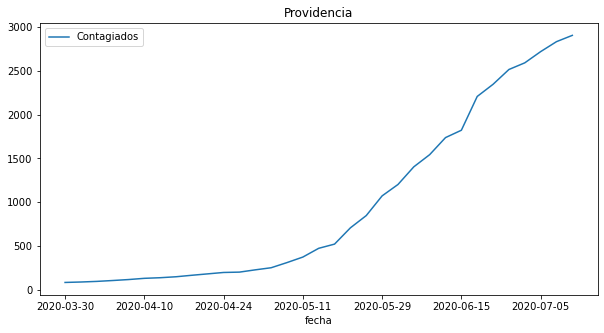

In [13]:
Comuna = 'Providencia'
sample = unpivoted[unpivoted['Comuna'] == Comuna]
sample.plot(x='fecha', y='Contagiados', title=Comuna, figsize=(10,5))

In [14]:
pivoted = unpivoted.pivot(index='fecha' , columns = 'Comuna', values='Contagiados').reset_index()
pivoted.dropna(inplace=True, axis='columns')
pivoted.head()

Comuna,fecha,Alhue,Buin,Calera_de_Tango,Cerrillos,Cerro_Navia,Colina,Conchali,Curacavi,El_Bosque,...,San_Bernardo,San_Joaquin,San_Jose_de_Maipo,San_Miguel,San_Pedro,San_Ramon,Santiago,Talagante,Tiltil,Vitacura
0,2020-03-30,0.0,7.0,6.0,0.0,19.0,32.0,14.0,5.0,18.0,...,32.0,13.0,0.0,25.0,0.0,0.0,127.0,0.0,0.0,83.0
1,2020-04-01,0.0,8.0,7.0,4.0,21.0,39.0,18.0,5.0,28.0,...,41.0,24.0,0.0,32.0,0.0,6.0,156.0,5.0,0.0,90.0
2,2020-04-03,0.0,14.0,7.0,4.0,26.0,47.0,22.0,5.0,35.0,...,53.0,28.0,0.0,39.0,0.0,9.0,173.0,6.0,0.0,100.0
3,2020-04-06,0.0,20.0,7.0,5.0,31.0,50.0,32.0,8.0,37.0,...,74.0,36.0,0.0,49.0,0.0,9.0,234.0,11.0,0.0,114.0
4,2020-04-08,0.0,20.0,8.0,11.0,36.0,62.0,38.0,9.0,46.0,...,79.0,42.0,0.0,56.0,0.0,12.0,271.0,14.0,4.0,114.0


In [15]:
#pivoted.plot(figsize=(30,10))

## Ahora comenzamos con la parte del mapa...

In [160]:
#!wget https://www.bcn.cl/siit/obtienearchivo?id=repositorio/10221/10396/1/division_comunal.zip
#!mv obtienearchivo\?id\=repositorio%2F10221%2F10396%2F1%2Fdivision_comunal.zip comunal.zip
#!unzip comunal
#!pip install geopandas

df_geo = gp.read_file('division_comunal.shp')
#df.NOM_REG.unique()

In [161]:
df_geo.NOM_REG.unique()

array(['Región de La Araucanía', 'Región de Los Lagos',
       'Región de Los Ríos', 'Región de Aysén del Gral.Ibañez del Campo',
       'Región de Antofagasta', 'Región de Atacama',
       "Región del Libertador Bernardo O'Higgins", 'Región de Coquimbo',
       'Región de Valparaíso', 'Región del Bío-Bío', 'Región del Maule',
       'Región Metropolitana de Santiago',
       'Región de Magallanes y Antártica Chilena', 'Zona sin demarcar',
       'Región de Arica y Parinacota', 'Región de Tarapacá'], dtype=object)

In [162]:
rmdf = df_geo[df_geo.NOM_PROV=='Santiago'].copy()
rmdf.drop(columns= {'NOM_REG', 'NOM_PROV'}, inplace=True)
rmdf.drop(columns={'DIS_ELEC', 'CIR_SENA', 'COD_COMUNA', 'SHAPE_LENG'}, inplace=True)
rmdf.rename(columns={'NOM_COM': 'Comuna', 'SHAPE_Le_1': 'shape_leng', 'SHAPE_Area': 'shape_area', 
                     'geometry': 'geometry'}, inplace=True)
rmdf['Comuna'] = rmdf['Comuna'].apply(lambda x: elimina_tildes(x))
print('Procesamos %d comunas en la Provincia de Santiago' %len(rmdf))

Procesamos 32 comunas en la Provincia de Santiago


In [135]:
rmdf.to_pickle('rm.pk')   # 780K! upload to quant.cl for reference (just repeat the above)

In [136]:
rmdf.head(5)

,Comuna,shape_leng,shape_area,geometry
177,Independencia,11718.687086,7.514746e+06,"POLYGON ((345884.003 6302609.684, 345884.800 6..."
178,La_Florida,49621.402175,7.103733e+07,"POLYGON ((366277.230 6293233.790, 366389.722 6..."
179,Lo_Barnechea,149865.511039,1.024735e+09,"POLYGON ((362574.869 6306774.165, 362695.732 6..."
180,Lo_Espejo,11389.045242,8.181655e+06,"POLYGON ((342637.767 6291726.784, 342771.084 6..."
181,Lo_Prado,10691.672491,6.535088e+06,"POLYGON ((341488.758 6296729.444, 341431.372 6..."


In [137]:
geo_comunas_json = list(rmdf['Comuna'].unique())
geo_comunas_min = list(df_metro['Comuna'].unique())

In [138]:
excluidas = []
for c in geo_comunas_min:
    if c not in geo_comunas_json:
        excluidas.append(c)
excluidas

['Alhue',
 'Buin',
 'Calera_de_Tango',
 'Colina',
 'Curacavi',
 'El_Monte',
 'Isla_de_Maipo',
 'Lampa',
 'Maria_Pinto',
 'Melipilla',
 'Padre_Hurtado',
 'Paine',
 'Penaflor',
 'Pirque',
 'Puente_Alto',
 'San_Bernardo',
 'San_Jose_de_Maipo',
 'San_Pedro',
 'Talagante',
 'Tiltil',
 'Desconocido_Metropolitana']

In [139]:
unpivoted['filtro'] = unpivoted['Comuna'].apply(lambda x: x not in excluidas)
final = unpivoted[unpivoted['filtro'] == True].copy()
final.drop(columns={'filtro'}, inplace=True)

In [140]:
len(final.Comuna.unique())

32

In [141]:
final['Codigo comuna'] = final['Codigo comuna'].astype(int)
final.head()

,Comuna,Codigo comuna,Poblacion,fecha,Contagiados
3,Cerrillos,13102,88956.0,2020-03-30,0.0
4,Cerro_Navia,13103,142465.0,2020-03-30,19.0
6,Conchali,13104,139195.0,2020-03-30,14.0
8,El_Bosque,13105,172000.0,2020-03-30,18.0
10,Estacion_Central,13106,206792.0,2020-03-30,16.0


In [142]:
#Función Prestada
def get_hex_colors(df, data_to_color, cmap = matplotlib.cm.Reds, log = False):
    
    '''
    This function takes the following arguments
        1. df:pandas DataFrame with the data.
        2. data_to_color: the column name with data based on which we want to create the color scale.
        3. cmap: colors you want to plot. You can use this to communicate different messages. For example: greens --> good, greys --> deaths.
                default is matplotlib.cm.Reds
                more about colormaps: https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
        3. log: if data has huge outliers, we can create the color map with a logarithic normalization. This way, the outliers won't "pale" our other data.
                default is False.
        
    '''
    
    cmap = cmap # define the color pallete you want. You can use Reds, Blues, Greens etc
    my_values = df[data_to_color] # get the value you wan to convert to colors
    
    mini = min(my_values) # get the min to normalize
    maxi= max(my_values) # get the max to normalize
    
    LOGMIN = 0.01 # arbitrary lower bound for log scale
    
    if log: 
        norm = matplotlib.colors.LogNorm(vmin=max(mini,LOGMIN), vmax=maxi) # normalize log data
    else:
        norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi) # create a color range
        
    colors = {value:matplotlib.colors.rgb2hex(cmap(norm(value))[:3]) for value in sorted(list(set(my_values)))} # create a dictionary with the total_infected or deaths as keys and colors as values
    
    return colors

In [143]:
def get_hex_colors_2(value, cats):
    '''
    Color paletter used from this website:
    
    https://colorbrewer2.org/#type=sequential&scheme=Reds&n=9
    
    The color selection will be based on the percentile each value is in.
    '''
    if value == 0:
        return "#FFFFFF"
    elif value in cats[0]:
        return "#fff5f0"
    elif value in cats[1]:
        return "#fee0d2"
    elif value in cats[2]:
        return "#fcbba1"
    elif value in cats[3]:
        return "#fc9272"
    elif value in cats[4]:
        return "#fb6a4a"
    elif value in cats[5]:
        return "#ef3b2c"
    elif value in cats[6]:
        return "#cb181d"
    elif value in cats[7]:
        return "#a50f15"
    elif value in cats[8]:
        return "#67000d"
    else:
        return "#000000"

In [144]:
final['fecha']=pd.to_datetime(final['fecha']).apply(lambda x: x - pd.DateOffset(days=1))

In [145]:
final.dtypes

Comuna                   object
Codigo comuna             int32
Poblacion               float64
fecha            datetime64[ns]
Contagiados             float64
dtype: object

In [146]:
final['Date_for_Folium']=(final['fecha'].astype(np.int64)// 10**9).astype('U10')

In [147]:
final.head()

,Comuna,Codigo comuna,Poblacion,fecha,Contagiados,Date_for_Folium
3,Cerrillos,13102,88956.0,2020-03-29,0.0,1585440000
4,Cerro_Navia,13103,142465.0,2020-03-29,19.0,1585440000
6,Conchali,13104,139195.0,2020-03-29,14.0,1585440000
8,El_Bosque,13105,172000.0,2020-03-29,18.0,1585440000
10,Estacion_Central,13106,206792.0,2020-03-29,16.0,1585440000


In [148]:
#----------------------------------------------------------------------------------
data_to_color = "Contagiados"
cats, bins =  pd.qcut(final[data_to_color].unique()[np.argsort(final[data_to_color].unique())], q = 9, retbins = True)
cats = cats.unique()

#----------------------------------------------------------------------------------

# value we will iterate in order to create the styledict
ccaas = list(final["Codigo comuna"].unique())
dates = list(final["Date_for_Folium"].unique())

# create the color dict and color column
final["COLORS"] = final[data_to_color].apply(get_hex_colors_2, args = [cats])

In [149]:
final.head()

,Comuna,Codigo comuna,Poblacion,fecha,Contagiados,Date_for_Folium,COLORS
3,Cerrillos,13102,88956.0,2020-03-29,0.0,1585440000,#FFFFFF
4,Cerro_Navia,13103,142465.0,2020-03-29,19.0,1585440000,#fff5f0
6,Conchali,13104,139195.0,2020-03-29,14.0,1585440000,#fff5f0
8,El_Bosque,13105,172000.0,2020-03-29,18.0,1585440000,#fff5f0
10,Estacion_Central,13106,206792.0,2020-03-29,16.0,1585440000,#fff5f0


In [150]:
# creates the styledict for the map
styledict = {}

# iterate the populate the styledict
for ccaa in ccaas:
    styledict[str(ccaa)] = {date: {'color': final[(final["Codigo comuna"] == ccaa) & (final["Date_for_Folium"] == date)]["COLORS"].values[0],
                                   'opacity': 1} for date in dates}

In [151]:
rmdf = rmdf.merge(df_id_comunas, left_on='Comuna', right_on='Comuna')

In [152]:
rmdf.drop(columns={'Comuna'}, inplace=True)
rmdf.set_index('Codigo comuna', inplace=True)
rmdf.head()

,shape_leng,shape_area,geometry
Codigo comuna,,,
13108,11718.687086,7.514746e+06,"POLYGON ((345884.003 6302609.684, 345884.800 6..."
13110,49621.402175,7.103733e+07,"POLYGON ((366277.230 6293233.790, 366389.722 6..."
13115,149865.511039,1.024735e+09,"POLYGON ((362574.869 6306774.165, 362695.732 6..."
13116,11389.045242,8.181655e+06,"POLYGON ((342637.767 6291726.784, 342771.084 6..."
13117,10691.672491,6.535088e+06,"POLYGON ((341488.758 6296729.444, 341431.372 6..."


In [153]:
rmdf

,shape_leng,shape_area,geometry
Codigo comuna,,,
13108,11718.687086,7.514746e+06,"POLYGON ((345884.003 6302609.684, 345884.800 6..."
13110,49621.402175,7.103733e+07,"POLYGON ((366277.230 6293233.790, 366389.722 6..."
13115,149865.511039,1.024735e+09,"POLYGON ((362574.869 6306774.165, 362695.732 6..."
13116,11389.045242,8.181655e+06,"POLYGON ((342637.767 6291726.784, 342771.084 6..."
13117,10691.672491,6.535088e+06,"POLYGON ((341488.758 6296729.444, 341431.372 6..."
13121,12493.791335,8.501305e+06,"POLYGON ((344777.523 6290845.527, 344725.441 6..."
13124,71971.661505,1.981070e+08,"POLYGON ((333478.856 6307318.963, 334024.312 6..."
13129,13986.827395,9.876877e+06,"POLYGON ((349154.307 6295053.269, 349203.099 6..."
13131,11691.258791,6.273610e+06,"POLYGON ((347868.343 6290008.545, 347933.772 6..."


In [154]:
geojson = rmdf.to_json()

In [155]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
m = folium.Map(location = (-33.38187075, -70.53537879464088), tiles='Stamen Toner', zoom_start = 8)

folium.Choropleth(
    geo_data = geojson,
    name = 'choropleth',
    data = final[final["fecha"] == max(final["fecha"])],
    columns = ['Codigo comuna', 'Contagiados'],
    key_on='feature.id',
    fill_color='RdPu',
    fill_opacity=17,
    line_opacity=0.2,
    legend_name = 'Casos confirmados Chile ultima fecha'
).add_to(m)

m

In [122]:
m = folium.Map(location=(-33.38187075, -70.53537879464088), tiles='Stamen Toner', zoom_start=10)

g = TimeSliderChoropleth(
    geojson, # get's the coordinates for each id 
    styledict = styledict # styledict contains for each id the timestamp and the color to plot.
)

m.add_child(g)
m

In [124]:
final[final["fecha"] == max(final["fecha"])]

,Comuna,Codigo comuna,Poblacion,fecha,Contagiados,Date_for_Folium,COLORS
1699,Cerrillos,13102,88956.0,2020-07-12,2772.0,1594512000,#cb181d
1700,Cerro_Navia,13103,142465.0,2020-07-12,5861.0,1594512000,#67000d
1702,Conchali,13104,139195.0,2020-07-12,5704.0,1594512000,#67000d
1704,El_Bosque,13105,172000.0,2020-07-12,5840.0,1594512000,#67000d
1706,Estacion_Central,13106,206792.0,2020-07-12,5761.0,1594512000,#67000d
1707,Huechuraba,13107,112528.0,2020-07-12,3474.0,1594512000,#cb181d
1708,Independencia,13108,142065.0,2020-07-12,6044.0,1594512000,#67000d
1710,La_Cisterna,13109,100434.0,2020-07-12,2932.0,1594512000,#cb181d
1711,La_Florida,13110,402433.0,2020-07-12,12589.0,1594512000,#67000d
1712,La_Granja,13111,122557.0,2020-07-12,6558.0,1594512000,#67000d
